## Классификация тональности комментариев


Интернет-магазин запускает новый сервис: теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Имеются данные с разметкой о токсичности правок. Необходимо обучить модель классифицировать комментарии на позитивные и негативные. Значение метрики качества модели F1 должно быть не меньше 0.75.

**1. Импорт модулей и библиотек**

In [ ]:
# импорты библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# импорты из стандартной библиотеки
import warnings

# импорты модулей текущего проекта
import torch

from tqdm import notebook

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer
)

import re

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.model_selection import (
                  GridSearchCV,
                  RandomizedSearchCV,
                  train_test_split,
                  cross_val_score
)

from sklearn.pipeline import Pipeline, make_pipeline

# импорт метрик
from sklearn.metrics import f1_score

# настройки
warnings.filterwarnings("ignore")

# импорты сторонних библиотек
! pip install transformers
import transformers
import transformers as ppb # pytorch transformers
from transformers import AutoModel, AutoTokenizer

! pip install cuda-python
import cuda

RANDOM_STATE = 42

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 90.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 14.3 MB/s eta 0:00:00


**2. Загрузка и предпросмотр данных**

In [ ]:
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [ ]:
df.sample(10)

,text,toxic
124876,WikiProject University of Oklahoma|class=Stub}...,0
147720,. Waving a guideline like this with no intelle...,0
118385,Wikipedia reguires that four warnings be sent ...,0
147404,old redneck jokes the name \n\nThe point of th...,1
150179,Ahh! \n\nIt's not vandalism! I'm asking why yo...,0
72707,My image is not vandalism \n\nPlease do not de...,0
79283,"Yeah, read the above comments. But don't see h...",0
24812,"Dude, I've changed IP's more than 50 times tod...",0
104128,stop being a fool\nIf he's going to post up ra...,1
144102,National Planning Policy Framework\nHiya Dudle...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [ ]:
display(df['toxic'].value_counts())
ratio = df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]
ratio

0    143106
1     16186
Name: toxic, dtype: int64

8.841344371679229

Значения в целевом признаке не сбалансированы.

**3. Предобработка данных**

3.1. Лемматизация

In [ ]:
%%time

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def preprocessing_lemmatize_words(text):
  #text = text.astype(str)
  text = text.lower()
  word_list = nltk.word_tokenize(text)
  joined = ' '.join(word_list)
  text_only = re.sub(r'[^a-zA-Z]', ' ', joined)
  clear_text = ' '.join(text_only.split())

  pos_tagged_text = nltk.pos_tag(clear_text.split())
  return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

# добавляем столбец с леммами в таблицу df, выводим результат
notebook.tqdm.pandas()
df['text_lemmatized'] = df['text'].progress_apply(lambda text: preprocessing_lemmatize_words(text))
df.head()


  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 10min 59s, sys: 6.08 s, total: 11min 5s
Wall time: 11min 33s


,text,toxic,text_lemmatized
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i ca n t make any real suggestion on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


Чтобы получить общее представление о тематике комментариев, построим два облака слов - отдельно для позитивных и негативных комментариев.

In [ ]:
clean_text = df.drop(['text'], axis=1)
clean_text

,toxic,text_lemmatized
0,0,explanation why the edits make under my userna...
1,0,d aww he match this background colour i m seem...
2,0,hey man i m really not try to edit war it s ju...
3,0,more i ca n t make any real suggestion on impr...
4,0,you sir be my hero any chance you remember wha...
...,...,...
159446,0,and for the second time of ask when your view ...
159447,0,you should be ashamed of yourself that be a ho...
159448,0,spitzer umm theres no actual article for prost...
159449,0,and it look like it be actually you who put on...


In [ ]:
clean_text_positive = clean_text.query('toxic == 0')
clean_text_negative = clean_text.query('toxic == 1')

In [ ]:
cloud_positive = ' '.join(clean_text_positive['text_lemmatized'])
cloud_negative = ' '.join(clean_text_negative['text_lemmatized'])

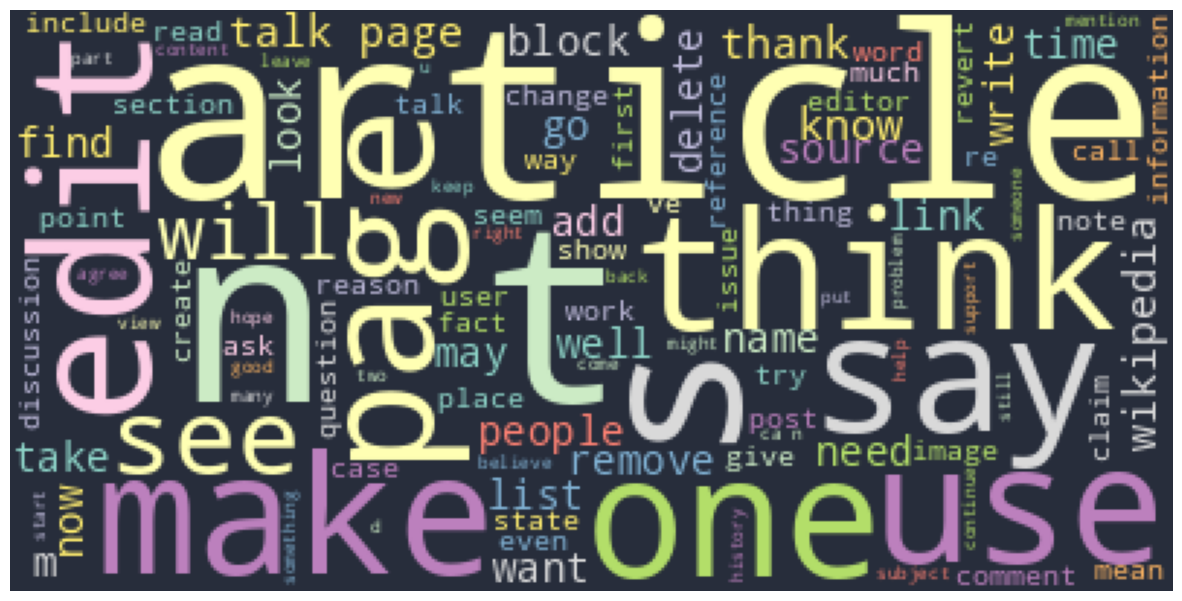

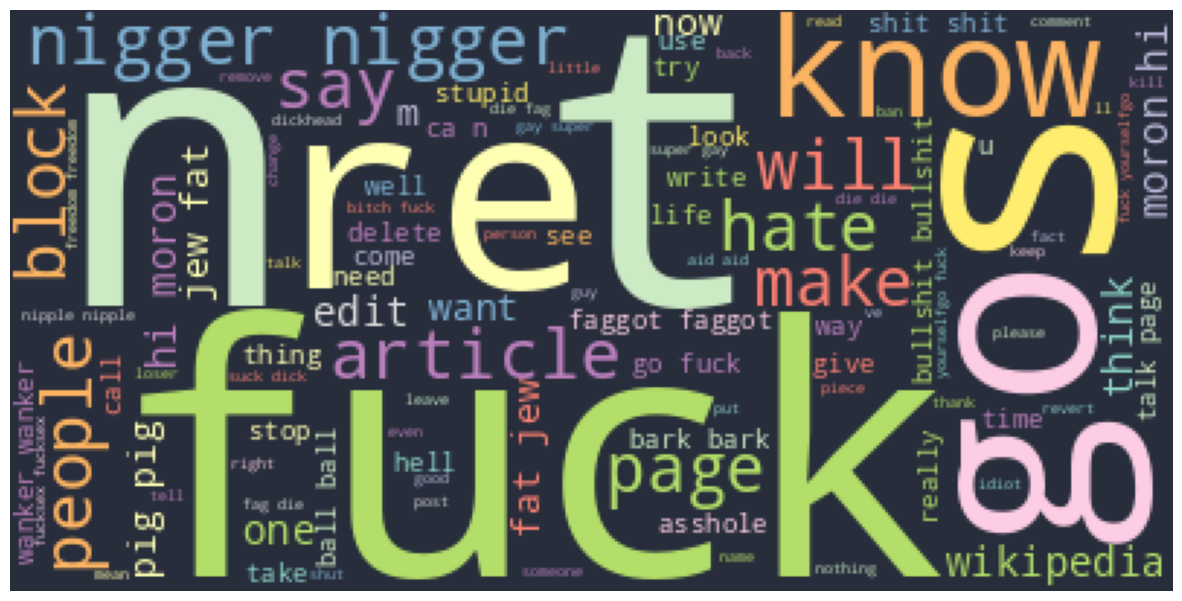

In [ ]:
for text in [cloud_positive, cloud_negative]:

    # генерируем облако слов и сохраняем в переменной cloud
    cloud = WordCloud(contour_width=10, contour_color='#2e3043',
                    background_color='#272d3b', colormap='Set3').generate(text)   #mask=cake_mask, , max_words=180

    # увеличим размер выводимой фигуры
    plt.figure(figsize=(15,10))

    # выводим облако слов на экран
    plt.imshow(cloud)

    # отключаем отображение осей
    plt.axis('off')
    #plt.show()

На графиках хорошо видно, что тональность позитивных и негативных комментариев резко отличается.

3.2. Выборки и признаки

In [ ]:
# разделяем данные на обучающую и тестовую выборки
train, test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE, stratify=df['toxic'])

In [ ]:
# выделяем признаки и таргет
X_train = train['text_lemmatized']
X_test = test['text_lemmatized']

y_train = train['toxic']
y_test = test['toxic']

print(X_train.shape)
print(X_test.shape)

(127433,)
(31859,)


In [ ]:
# проверим бланс значений в целевом признаке
print('Баланс значений в обучающей выборке:')
print(y_train.value_counts()[0] / y_train.value_counts().sum())
print(y_train.value_counts()[1] / y_train.value_counts().sum())
print()
print('Баланс значений в тестовой выборке:')
print(y_test.value_counts()[0] / y_test.value_counts().sum())
print(y_test.value_counts()[1] / y_test.value_counts().sum())


Баланс значений в обучающей выборке:
0.898385818430077
0.10161418156992302

Баланс значений в тестовой выборке:
0.8983960576289275
0.10160394237107254


3.3. Стоп-слова

In [ ]:
# добавляем стоп-слова
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
len(stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


179

In [ ]:
stopwords = list(stopwords)
print(stopwords)

["isn't", 'was', 'before', 'be', 'ours', 'i', 'our', "you'd", 'not', 'were', 'did', 'against', 'theirs', 'them', 'under', 's', 'some', 'most', "haven't", 'him', 'so', 'he', 'after', 'to', 'too', 'my', 'wouldn', 'now', 'me', 'with', "you're", 'aren', 're', "aren't", 'up', 'does', 'we', 'mightn', 'than', 'she', 'am', 'no', "it's", 'o', "wouldn't", 'having', 'where', 'don', 'same', 'couldn', 'its', "doesn't", 'himself', 'very', 'other', 'of', 'such', 'the', 'once', 'a', 'because', 'below', "needn't", 'this', 'when', 'further', 've', 'if', 'y', 'her', 'off', 'ourselves', 'each', 'which', 'weren', 'then', "shouldn't", 'about', 'itself', 'should', "you'll", 'for', 'had', 'there', 'yourselves', 'wasn', 'how', 'why', 'is', 'nor', 'are', "mustn't", 'that', 'haven', 'any', 'mustn', 'an', "couldn't", 'or', 'ain', 'yourself', "wasn't", 'herself', "didn't", "that'll", "shan't", 'through', 'between', 'again', 'until', 'have', 'but', 'do', 'from', 'shan', 'you', 'on', 'his', "don't", 'all', 'll', 'ov

Предварительную обработку завершили. Данные готовы к моделированию.

**4. Модели**

В рамках данного исследования обучим три модели:
1.   LogisticRegression
2.   MultinomialNB
3.   LGBMClassifier

В качестве предварительной обработки данных к каждой из трёх моделей применим метод TF-IDF.


In [ ]:
# подготовим результирующую таблицу
results = pd.DataFrame({
    'Preprocessing model' : [], 'Learning model' : [], 'Best estimator' : [], 'F1-score(train)' : [], 'F1-score(valid)' : []
})

In [ ]:
# подготовим список моделей
models = [
    LogisticRegression(random_state=RANDOM_STATE),
    MultinomialNB(),
    lgb.LGBMClassifier(random_state=RANDOM_STATE)
]

In [ ]:
# пропишем пайплайны для выбранных моделей

# LogisticRegression pipeline
lr_pipe = Pipeline([
 ('tvec', TfidfVectorizer(stop_words=stopwords)),
 ('lr', LogisticRegression(random_state=RANDOM_STATE))
])

# MultinomialNB pipeline
nb_pipe = Pipeline([
 ('tvec', TfidfVectorizer(stop_words=stopwords)),
 ('nb', MultinomialNB())
])

# LGBMClassifier pipeline
lgbm_pipe = Pipeline([
 ('tvec', TfidfVectorizer(stop_words=stopwords)),
 ('lgbm', lgb.LGBMClassifier(random_state=RANDOM_STATE))
])

In [ ]:
# создадим списки параметров для перебора в GridSearchCV

# параметры для TFIDF Vectorizer gridsearch
tf_params = {
             'tvec__max_features' : [100, 200],
             'tvec__ngram_range' : [(2, 2), (2, 3), (3, 3)]
              #'tvec__stop_words': ['english']
              }

# параметры для моделей:

# LogisticRegression
lr_grid_params = {
                   'lr__C' : [5, 7, 9, 10],
                   #'lr__penalty' : ['l1', 'l2']
                   'lr__penalty' : ['none', 'l2']
                   }

# LGBMClassifier
lgbm_grid_params = {
                     'tvec__max_features':[100, 200],
                     'tvec__ngram_range': [(2, 2), (3, 3)],
                     #'tvec__stop_words': ['english'],
                     'lgbm__n_estimators': [100, 200, 300],
                     'lgbm__learning_rate': [0.1, 0.3]
                      }

In [ ]:
%%time
notebook.tqdm.pandas()

# GridSearch LogisticRegression
lr_gs = GridSearchCV(lr_pipe, param_grid=lr_grid_params, cv=3, verbose=1, n_jobs=-1,  scoring='f1', error_score='raise')
lr_gs.fit(X_train, y_train)
#lr_gs.score(X_train, y_train)
lr_gs.best_score_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
CPU times: user 16.3 s, sys: 10.5 s, total: 26.8 s
Wall time: 3min 52s


0.7684421498737392

In [ ]:
%%time
notebook.tqdm.pandas()

# GridSearch for TFIDFVectorizer (MultinomialNB)
nb_gs = GridSearchCV(nb_pipe, param_grid=tf_params, cv=3, verbose=1, n_jobs=-1, scoring='f1')
nb_gs.fit(X_train, y_train)
#nb_gs.score(X_train, y_train)
nb_gs.best_score_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
CPU times: user 19.7 s, sys: 1.98 s, total: 21.6 s
Wall time: 5min 1s


0.08238856417132703

In [ ]:
%%time
notebook.tqdm.pandas()

# LGBMClassifier pipeline
lgbm_pipe = Pipeline([
 ('tvec', TfidfVectorizer(stop_words=stopwords)),
 ('lgbm', lgb.LGBMClassifier(random_state=RANDOM_STATE))
])

# LGBMClassifier
lgbm_grid_params = {
                     #'tvec__max_features':[100, 200],
                     #'tvec__ngram_range': [(2, 2), (3, 3)],
                     #'tvec__stop_words': ['english'],
                     'lgbm__n_estimators': [100, 200, 300],
                     'lgbm__learning_rate': [0.1, 0.3]
                      }

# GridSearch for LGBMClassifier
lgbm_gs = GridSearchCV(lgbm_pipe, param_grid=lgbm_grid_params, cv=3, verbose=1, n_jobs=-1, scoring='f1')
lgbm_gs.fit(X_train, y_train)
#lgbm_gs.score(X_train, y_train)
lgbm_gs.best_score_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[LightGBM] [Info] Number of positive: 12949, number of negative: 114484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 23.215963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 544750
[LightGBM] [Info] Number of data points in the train set: 127433, number of used features: 9970
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101614 -> initscore=-2.179417
[LightGBM] [Info] Start training from score -2.179417
CPU times: user 1min 54s, sys: 2.95 s, total: 1min 57s
Wall time: 19min 37s


0.7691755877472354

In [ ]:
%%time

for element in [lr_gs, nb_gs, lgbm_gs]:
  name = str(element)[0]
  #name = element

  globals()['results'] = globals()['results'].append(
                           {'Preprocessing model' : 'TFIDF',
                            'Learning model' : name,
                            'Best estimator' : element.best_estimator_,
                            'F1-score(train)' : round(element.best_estimator_.score(X_train, y_train), 2),
                            'F1-score(valid)' : round(element.best_score_, 2)},
                             ignore_index=True)


CPU times: user 35.2 s, sys: 68.9 ms, total: 35.3 s
Wall time: 35.4 s


In [ ]:
results

,Preprocessing model,Learning model,Best estimator,F1-score(train),F1-score(valid)
0,TFIDF,G,"(TfidfVectorizer(stop_words=[""isn't"", 'was', '...",0.98,0.77
1,TFIDF,G,"(TfidfVectorizer(max_features=200, ngram_range...",0.90,0.08
2,TFIDF,G,"(TfidfVectorizer(stop_words=[""isn't"", 'was', '...",0.98,0.77


Из трёх исследованных моделей лучший скор на валидационной выборке показала модель LogisticRegression, F1 = 0.77. Именно ее выбираем в качестве лучшей и проверяем на  тестовой выборке.

**5. Тестирование лучшей модели.**

In [ ]:
# проверим лучшие модели на тестовой выборке

# проверка для LogisticRegression()
test_f1_score_lr = f1_score(y_test,  lr_gs.best_estimator_.predict(X_test))
print('Модель LogisticRegression(), метод предобработки - TF-IDF, F1 на тестовой выборке =', test_f1_score_lr.round(2))

# проверка для LGBMClassifier()
test_f1_score_lgbm = f1_score(y_test,  lgbm_gs.best_estimator_.predict(X_test))
print('Модель LGBMClassifier(), метод предобработки - TF-IDF, F1 на тестовой выборке =', test_f1_score_lgbm.round(2))

Модель LogisticRegression(), метод предобработки - TF-IDF, F1 на тестовой выборке = 0.78
Модель LGBMClassifier(), метод предобработки - TF-IDF, F1 на тестовой выборке = 0.77


На тестовой выборке модель LogisticRegression с TF-IDF показала лучший результат: F1-метрика = 0.78, в то время как модель LGBMClassifier с TF-IDF смогла выдать только F1-метрику = 0.77.

### Обучение с моделью DistilBERT

In [ ]:
# Загрузка предобученной модели DistilBERT и токенизатора
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Загрузка предобученной модели/токенизатора
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
%%time
# токенизация
tokenized = df['text'].apply(
    # Ограничиваем размер токена, поскольку: длина последовательности индексов токенов больше указанной максимальной длины последовательности для этой модели (631 > 512).
    # Прогон этой последовательности через модель приведет к ошибкам индексации.
    (lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))
    )

CPU times: user 4min 32s, sys: 669 ms, total: 4min 33s
Wall time: 4min 35s


In [ ]:
tokenized

0         [101, 7526, 2339, 1996, 10086, 2015, 2081, 210...
1         [101, 1040, 1005, 22091, 2860, 999, 2002, 3503...
2         [101, 4931, 2158, 1010, 1045, 1005, 1049, 2428...
3         [101, 1000, 2062, 1045, 2064, 1005, 1056, 2191...
4         [101, 2017, 1010, 2909, 1010, 2024, 2026, 5394...
                                ...                        
159446    [101, 1000, 1024, 1024, 1024, 1024, 1024, 1998...
159447    [101, 2017, 2323, 2022, 14984, 1997, 4426, 200...
159448    [101, 13183, 6290, 26114, 1010, 2045, 2015, 20...
159449    [101, 1998, 2009, 3504, 2066, 2009, 2001, 2941...
159450    [101, 1000, 1998, 1012, 1012, 1012, 1045, 2428...
Name: text, Length: 159292, dtype: object

In [ ]:
# паддинг
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
# маскинг
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(159292, 512)

In [ ]:
# вычисление фичей для BERT в google collab
%%time
from tqdm import notebook
batch_size = 64    #200
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).cuda() # закидываем тензор на GPU
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cuda()

        with torch.no_grad():
            model.cuda()
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy()) # перевод обратно на проц, чтобы в нумпай кинуть
        del batch
        del attention_mask_batch
        del batch_embeddings

  0%|          | 0/2488 [00:00<?, ?it/s]

CPU times: user 43min 55s, sys: 4.57 s, total: 43min 59s
Wall time: 44min 21s


In [ ]:
# фиксируем фичи и таргет
features = np.concatenate(embeddings)
labels = df['toxic'][:159232] # выравниваем размер целевого признака по фичам

In [ ]:
# делим на выборки
features_train, features_test, labels_train, labels_test = train_test_split(features, labels)

In [ ]:
# корректируем список моделей (удаляем модели с однозначно низкими результатами)
models_for_bert = [
    LogisticRegression(random_state=RANDOM_STATE),
    lgb.LGBMClassifier(random_state=RANDOM_STATE)
]

In [ ]:
# LogisticRegression pipeline
lr_pipe = Pipeline([
 #('tvec', TfidfVectorizer(stop_words=stopwords)),
 ('lr', LogisticRegression(random_state=RANDOM_STATE))
])

# LGBMClassifier pipeline
lgbm_pipe = Pipeline([
 #('tvec', TfidfVectorizer(stop_words=stopwords)),
 ('lgbm', lgb.LGBMClassifier(random_state=RANDOM_STATE))
])

In [ ]:
# создадим списки параметров моделей для перебора в GridSearchCV

# LogisticRegression
lr_bert_grid_params = {
                   'lr__C' : [5, 7, 9, 10],
                   'lr__penalty' : ['l1', 'l2']
                   }

# LGBMClassifier
lgbm_bert_grid_params = {
                     'lgbm__n_estimators': [100, 200],
                     'lgbm__learning_rate': [0.1, 0.3]
                      }

In [ ]:
%%time
# GridSearch LogisticRegression
lr_gs_bert = GridSearchCV(lr_pipe, param_grid=lr_bert_grid_params, cv=3, verbose=1, n_jobs=-1,  scoring='f1')
lr_gs_bert.fit(features_train, labels_train)
lr_gs_bert.best_score_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
CPU times: user 24.5 s, sys: 1.75 s, total: 26.3 s
Wall time: 2min 8s


0.7376112343514983

In [ ]:
%%time
# GridSearch for LGBMClassifier
lgbm_gs_bert = GridSearchCV(lgbm_pipe, param_grid=lgbm_bert_grid_params, cv=3, verbose=1, n_jobs=-1, scoring='f1')
lgbm_gs_bert.fit(features_train, labels_train)
lgbm_gs_bert.best_score_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Info] Number of positive: 12173, number of negative: 107251
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.716071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 119424, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101931 -> initscore=-2.175951
[LightGBM] [Info] Start training from score -2.175951
CPU times: user 2min 18s, sys: 1.86 s, total: 2min 20s
Wall time: 15min 47s


0.711153466847113

**ВЫВОД по DistilBERT:**

DistilBERT показала неожиданно плохой результат. Метрики F1 ниже, чем у обычных моделей:
     
    F1=0.74 для DistilBERT + LogisticRegression,
    F1=0.71 для DistilBERT + LGBMClassifier
    
По условию задачи, результат на тесте должен быть не менее 0.75, поэтому наш эксперимент с  DistilBERT считаю неудавшимся.

### Обучение с моделью Toxic - BERT

Попробуем еще один вариант - модель BERT, предобученную на токсичных текстах

In [ ]:
# используем версию BERT, предобученную на токсичных текстах

model_name = "unitary/toxic-bert" # модель BERT обученная на токсичных текстах

model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# вычисление токенов для BERT в google collab
tokenized = df['text'].apply(
    # Ограничиваем размер токена, поскольку: длина последовательности индексов токенов больше указанной 
    # максимальной длины последовательности для этой модели (631 > 512).
    # Прогон этой последовательности через модель приведет к ошибкам индексации.
   lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))

max_len = 0
for i in tokenized.values:
   if len(i) > max_len:
       max_len = len(i)

input_ids = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(input_ids != 0, 1, 0)

# вычисление фичей для BERT в google collab
from tqdm import notebook
batch_size = 64  #100
embeddings = []
for i in notebook.tqdm(range(input_ids.shape[0] // batch_size)):
       batch = torch.LongTensor(input_ids[batch_size*i:batch_size*(i+1)]).cuda() # закидываем тензор на GPU
       attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cuda()

       with torch.no_grad():
           model.cuda()
           batch_embeddings = model(batch, attention_mask=attention_mask_batch)

       embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy()) # перевод обратно на проц, чтобы в нумпай кинуть
       del batch
       del attention_mask_batch
       del batch_embeddings

  0%|          | 0/2488 [00:00<?, ?it/s]

In [ ]:
features = np.concatenate(embeddings)
labels = df['toxic'][:159232]

In [ ]:
# разделяем данные на обучающую и тестовую выборки
features_train, features_test, labels_train, labels_test = train_test_split(features, labels)


In [ ]:
%%time

# GridSearch LogisticRegression

lr_gs_bert_toxic = GridSearchCV(lr_pipe, param_grid=lr_bert_grid_params, cv=3, verbose=1, n_jobs=-1,  scoring='f1')
lr_gs_bert_toxic.fit(features_train, labels_train)
#lr_gs.score(X_train, y_train)
lr_gs_bert_toxic.best_score_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
CPU times: user 23.9 s, sys: 1.94 s, total: 25.9 s
Wall time: 2min 3s


0.9441804515449279

In [ ]:
%%time

# GridSearch for LGBMClassifier

lgbm_gs_bert_toxic = GridSearchCV(lgbm_pipe, param_grid=lgbm_bert_grid_params, cv=3, verbose=1, n_jobs=-1, scoring='f1')
lgbm_gs_bert_toxic.fit(features_train, labels_train)
#lgbm_gs.score(X_train, y_train)
lgbm_gs_bert_toxic.best_score_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Info] Number of positive: 12094, number of negative: 107330
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 3.246039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 119424, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101269 -> initscore=-2.183199
[LightGBM] [Info] Start training from score -2.183199
CPU times: user 2min 16s, sys: 1.65 s, total: 2min 17s
Wall time: 13min 37s


0.9454129855239879

In [ ]:
# подготовим результирующую таблицу для BERT
results_bert = pd.DataFrame({
    'Preprocessing model' : [], 'Best estimator' : [], 'F1-score(train)' : [], 'F1-score(valid)' : []
})

In [ ]:
def final_results_bert(estimator):
  globals()['results_bert'] = globals()['results_bert'].append(
                           {'Preprocessing model' : 'DistilBERT',
                            'Best estimator' : estimator.best_estimator_,
                            'F1-score(train)' : round(estimator.best_estimator_.score(features_train, labels_train), 2),
                            'F1-score(valid)' : round(estimator.best_score_, 2)},
                             ignore_index=True)

In [ ]:
for element in [lr_gs_bert, lgbm_gs_bert, lr_gs_bert_toxic, lgbm_gs_bert_toxic]:
  name = str(element)[0]
  #name = element
  final_results_bert(element)

In [ ]:
results_bert.sort_values(by='F1-score(valid)', ascending=False).reset_index()

,index,Preprocessing model,Best estimator,F1-score(train),F1-score(valid)
0,3,DistilBERT,"(LGBMClassifier(n_estimators=200, random_state...",1.00,0.95
1,2,DistilBERT,"(LogisticRegression(C=5, random_state=42))",0.99,0.94
2,0,DistilBERT,"(LogisticRegression(C=10, random_state=42))",0.95,0.74
3,1,DistilBERT,"(LGBMClassifier(n_estimators=200, random_state...",0.96,0.71


Метрики на предобученной Toxic-BERT несопоставимо выше. Лучший скор дает LogisticRegression (F1=0.95), ее и проверим на тестовой выборке.

In [ ]:
# проверим лучшую модель toxic-bert на тестовой выборке

test_f1_score = f1_score(labels_test, lr_gs_bert_toxic.predict(features_test))
print('Модель LogisticRegression(), метод предобработки BERT_"unitary/toxic-bert", F1 на тестовой выборке =', test_f1_score.round(2))

Модель LogisticRegression(), метод предобработки BERT_"unitary/toxic-bert", F1 на тестовой выборке = 0.95

**ИТОГОВЫЙ ВЫВОД:**

В рамках поставленной задачи:

   1. На этапе знакомства с данными и предобработки: исходные данные были очищены от лишних знаков, была проведена лемматизация текста и его общий анализ.
    
   2. На этапе подготовки данных: использован метод TF-IDF, удалены стоп-слова. Также как вариант предварительной подготовки данных использована языковая модель BERT в двух вариантах(DistilBERT и DistilBERT "unitary/toxic-bert")
    
   3. На этапе моделирования: обучены модели и выбраны лучшие из них на валидационной выборке.
    
   Были исследованы следующие модели:

    - LogisticRegression
    - MultinomialNB
    - LGBMClassifier
    - DistilBERT
    - DistilBERT "unitary/toxic-bert" - версия, предобученная на токсичных текстах.

   По условию задачи метрикой оценки качества моделей выбрана F1-мера. Для каждой из исследованных моделей была рассчитана метрика качества.
    
   4. На этапе тестирования: протестированы две модели.
    
    - лучшими среди предобученных методом TF-IDF оказались две модели: LogisticRegression() и LGBMClassifier, F1 на тесте у обеих = 0.77;
    - лучшей среди моделей, обученных с использованием BERT, оказалась также модель LogisticRegression() с предобработкой данных на BERT "unitary/toxic-bert", F1 модели на тесте = 0.95.